<a class="anchor" id="Introduction"></a>
### Introduction

Table of Contents

1. [Introduction](#Introduction)
2. [Imports](#Imports)
3. [Basic Data Setup](#basic-data-setup)
4. [Exploratory Data Analysis](#eda)
    - [Data Splitting & Feature Importance](#data-split)
5. [Baseline Model](#baseline)
6. [Feature & Parameter Tuning](#feature-tuning)
    - [Improving Linear Regressions](#lin-reg)
    - [Decision Tree Models](#dec-tree)
    - [XGBoost Models](#XGBoost)
7. [Training the Final Model](#final)

In 2011, a research was published in The American Naturalist, detailing how the colour and brightness of a certain species of Poison Frog are indicators for their toxicity levels. 

Poisonous or toxic organisms often present bold colourations and flashy patterns instead of subdued tones that would promote camouflage. This might seem disandvantageous at first, as such organisms are more likely to be noticed by whatever species predate them. However, this is actually a defense mechanism - the bold colours serve as an advertisement for their toxicity, shouting out "Do not eat me!" to any potential predators. Thus even when noticed, predators will move past them as they have learnt that the bright colours and loud patterns mean the prey is unsuitable for consumption. 

There have been theories in the past of how the colour of the frog may relate to its toxicity. A lot of these were disproved, with evidence to the contrary having also been found. This study focused on the inherent reflectance of the frog's colour, independent of who the viewer was, in relation to its toxicity levels. By this new metric, and with a wider range of colour morphs, the study found a strong correlation between the conspiciousness of a frog and its toxicity level. 

This project hopes to build a model that will be able to predict the toxicity of the poison frog based on its colours and brightness alone. 

<a class="anchor" id="Imports"></a>
### Imports

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import bentoml

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

<a class="anchor" id="basic-data-setup"></a>
### Basic Data Setup

In [68]:
data = "./data/Data_MaanCummings_2011_ AmNat52931_ByPop.txt"

In [69]:
df = pd.read_table(data)
df.head()

pop  pop#  ntox          tox        toxse     normtox    normtoxse viewer  \
0  AG   4.0   7.0  1.088161949  0.098258171  0.63290169  0.057149363   bird   
1  AG   4.0   7.0  1.088161949  0.098258171  0.63290169  0.057149363   bird   
2  AG   4.0   7.0  1.088161949  0.098258171  0.63290169  0.057149363   bird   
3  AG   4.0   7.0  1.088161949  0.098258171  0.63290169  0.057149363   bird   
4  AG   4.0   7.0  1.088161949  0.098258171  0.63290169  0.057149363   bird   

  background noise vord           dl           ds          euc           qt  \
0       heli    sp    d  0.663722415  0.233671337  0.555260377  3689.650359   
1       bark    sp    d  0.112856785  0.476213307  0.209312332  3689.650359   
2       leaf    sp    d  0.713476708  0.589575949  0.687093613  3689.650359   
3       bark   fix    d  0.112856785  0.476213307  0.209312332  3689.650359   
4       heli   fix    d  0.663722415  0.233671337  0.555260377  3689.650359   

          qtse       normqt    dluvminus    dsuvminus   eucuvminus  
0  160.5477775  0.427836697  0.663722415  0.233207331  0.554822449  
1  160.5477775  0.427836697  0.112856785  0.468019096  0.206925170  
2  160.5477775  0.427836697  0.713476708  0.585557048  0.686149468  
3  160.5477775  0.427836697          NaN          NaN          NaN  
4  160.5477775  0.427836697          NaN          NaN          NaN

The column names provdided in the data are difficult to remember, so I updated them based on descriptions provided in the README file of the data. (The README is also included in the data folder.)


pop	- abbreviation of frog population 

pop# - population number 

ntox - number of frog individuals that toxicity estimate is based on

tox - toxicity estimate (not normalised, but adjusted for dosage)

toxse - standard error of tox

normtox - toxicity estimate (normalised)

normtoxse - standard error of normtox

viewer - pumilio, bird, crab or snake (see article methods section)

background - bark, heli (Heliconia), leaf (leaf litter) (see article methods section)

noise - (see article methods section)

vord - v=ventral reflectance, d=dorsal reflectance

dl - viewer-specific luminance (brightness) contrast

ds - viewer-specific chromatic (colour) contrast

euc - viewer-specific conspicuousness (incorporating both ds and dl)

qt - viewer-independent brightness (total reflectance)

qtse - standard error of qt

normqt - normalised qt

dluvminus - viewer-specific luminance (brightness) contrast for bird visual system without UV cone

dsuvminus - viewer-specific chromatic (colour) contrast for bird visual system without UV cone

eucuvminus - viewer-specific conspicuousness (incorporating both ds and dl) for bird visual system without UV cone

Missing data indicated by NA


In [70]:
columns = ['pop', 'pop_number', 'n_tox', 'toxicity', 'toxicity_se', 'toxicity_normalised', 'toxicity_norm_se', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_chrom_cont', 'vs_conspic', 'vi_brightness', 'vi_bright_se', 'vi_bright_normalised', 'bird_lumin_cont', 'bird_chrom_cont', 'bird_conspic_cont']

df.columns = columns
df.head().T

0            1            2            3  \
pop                            AG           AG           AG           AG   
pop_number                    4.0          4.0          4.0          4.0   
n_tox                         7.0          7.0          7.0          7.0   
toxicity              1.088161949  1.088161949  1.088161949  1.088161949   
toxicity_se           0.098258171  0.098258171  0.098258171  0.098258171   
toxicity_normalised    0.63290169   0.63290169   0.63290169   0.63290169   
toxicity_norm_se      0.057149363  0.057149363  0.057149363  0.057149363   
viewer                       bird         bird         bird         bird   
background                   heli         bark         leaf         bark   
noise                          sp           sp           sp          fix   
v_or_d                          d            d            d            d   
vs_lumin_cont         0.663722415  0.112856785  0.713476708  0.112856785   
vs_chrom_cont         0.233671337  0.476213307  0.589575949  0.476213307   
vs_conspic            0.555260377  0.209312332  0.687093613  0.209312332   
vi_brightness         3689.650359  3689.650359  3689.650359  3689.650359   
vi_bright_se          160.5477775  160.5477775  160.5477775  160.5477775   
vi_bright_normalised  0.427836697  0.427836697  0.427836697  0.427836697   
bird_lumin_cont       0.663722415  0.112856785  0.713476708          NaN   
bird_chrom_cont       0.233207331  0.468019096  0.585557048          NaN   
bird_conspic_cont     0.554822449   0.20692517  0.686149468          NaN   

                                4  
pop                            AG  
pop_number                    4.0  
n_tox                         7.0  
toxicity              1.088161949  
toxicity_se           0.098258171  
toxicity_normalised    0.63290169  
toxicity_norm_se      0.057149363  
viewer                       bird  
background                   heli  
noise                         fix  
v_or_d                          d  
vs_lumin_cont         0.663722415  
vs_chrom_cont         0.233671337  
vs_conspic            0.555260377  
vi_brightness         3689.650359  
vi_bright_se          160.5477775  
vi_bright_normalised  0.427836697  
bird_lumin_cont               NaN  
bird_chrom_cont               NaN  
bird_conspic_cont             NaN

<a class="anchor" id="eda"></a>
### Exploratory Data Analysis

In [71]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pop                   552 non-null    object 
 1   pop_number            528 non-null    float64
 2   n_tox                 552 non-null    float64
 3   toxicity              552 non-null    float64
 4   toxicity_se           552 non-null    float64
 5   toxicity_normalised   552 non-null    float64
 6   toxicity_norm_se      552 non-null    float64
 7   viewer                516 non-null    object 
 8   background            516 non-null    object 
 9   noise                 540 non-null    object 
 10  v_or_d                528 non-null    object 
 11  vs_lumin_cont         516 non-null    float64
 12  vs_chrom_cont         516 non-null    float64
 13  vs_conspic            516 non-null    float64
 14  vi_brightness         528 non-null    float64
 15  vi_bright_se          5

In [72]:
df.describe().T

count              mean               std  \
pop_number            528.0     6.00000000000     3.16527650168   
n_tox                 552.0     4.82608695652     0.81646436627   
toxicity              552.0     0.90457146017     0.45057746973   
toxicity_se           552.0     0.07711346530     0.02822564557   
toxicity_normalised   552.0     0.52612095691     0.26206691219   
toxicity_norm_se      552.0     0.04485108361     0.01641672814   
vs_lumin_cont         516.0     0.64098484048     0.26920619343   
vs_chrom_cont         516.0     0.64294017783     0.28868880014   
vs_conspic            516.0     0.67984057212     0.24973851049   
vi_brightness         528.0  7773.94906081818  3409.62487635278   
vi_bright_se          528.0   462.42157252273   230.00878805250   
vi_bright_normalised  480.0     0.61805746940     0.19729639141   
bird_lumin_cont        33.0     0.47694832291     0.31540385809   
bird_chrom_cont        33.0     0.40285996145     0.26377613784   
bird_conspic_cont      33.0     0.47369501445     0.28016040967   

                                 min               25%              50%  \
pop_number               1.000000000     3.00000000000     6.0000000000   
n_tox                    4.000000000     4.00000000000     5.0000000000   
toxicity                 0.337734972     0.50458254100     0.8611684390   
toxicity_se              0.031678160     0.05150294300     0.0771714580   
toxicity_normalised      0.196434947     0.29347758700     0.5008766950   
toxicity_norm_se         0.018424795     0.02995537500     0.0448848140   
vs_lumin_cont            0.011418844     0.47249726275     0.6981751465   
vs_chrom_cont            0.013385652     0.45294261325     0.7378053430   
vs_conspic               0.051274348     0.48752551450     0.7347415080   
vi_brightness         3689.650359000  5371.79359600000  7322.6854005000   
vi_bright_se           160.547777500   301.89259420000   373.4712037500   
vi_bright_normalised     0.359125138     0.46104768050     0.5571056665   
bird_lumin_cont          0.011418844     0.23248955700     0.3941537390   
bird_chrom_cont          0.029681877     0.17116810100     0.3935289400   
bird_conspic_cont        0.049892901     0.25409393500     0.4149172500   

                                  75%              max  
pop_number               9.0000000000     11.000000000  
n_tox                    5.0000000000      7.000000000  
toxicity                 1.3980599960      1.719322236  
toxicity_se              0.1068350400      0.113805927  
toxicity_normalised      0.8131459980      1.000000000  
toxicity_norm_se         0.0621378810      0.066192320  
vs_lumin_cont            0.8363540850      1.000000000  
vs_chrom_cont            0.8700506165      1.000000000  
vs_conspic               0.8743829190      1.000000000  
vi_brightness         8981.5272500000  16946.691780000  
vi_bright_se           746.8997085000    945.940487600  
vi_bright_normalised     0.7045137345      1.000000000  
bird_lumin_cont          0.8070076030      1.000000000  
bird_chrom_cont          0.5297128470      1.000000000  
bird_conspic_cont        0.6909482540      1.000000000

There seems to be a very high percentage of rows with no data provided for the three columns `bird_lumin_cont`, `bird_chrom_cont`, and `bird_conspic_cont`. We will have to check further in EDA to see how much of a difference they are making on 'toxicity'. 

In [7]:
df.isnull().sum()

pop                       3
pop_number               27
n_tox                     3
toxicity                  3
toxicity_se               3
toxicity_normalised       3
toxicity_norm_se          3
viewer                   39
background               39
noise                    15
v_or_d                   27
vs_lumin_cont            39
vs_chrom_cont            39
vs_conspic               39
vi_brightness            27
vi_bright_se             27
vi_bright_normalised     75
bird_lumin_cont         522
bird_chrom_cont         522
bird_conspic_cont       522
dtype: int64

I decided to get rid of the 'pop_number' feature since the 'pop' column serves about the same purpose. I also dropped the last three columns for the sheer amount of missing values. I wish that was not the case because they seemed to be interesting features... 

In [8]:
df_selected = df[['pop', 'n_tox', 'toxicity', 'toxicity_se', 'toxicity_normalised', 'toxicity_norm_se', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_chrom_cont', 'vs_conspic', 'vi_brightness', 'vi_bright_se', 'vi_bright_normalised']
].fillna(0).drop_duplicates()
df_selected.head().T

0            1            2            3  \
pop                            AG           AG           AG           AG   
n_tox                         7.0          7.0          7.0          7.0   
toxicity              1.088161949  1.088161949  1.088161949  1.088161949   
toxicity_se           0.098258171  0.098258171  0.098258171  0.098258171   
toxicity_normalised    0.63290169   0.63290169   0.63290169   0.63290169   
toxicity_norm_se      0.057149363  0.057149363  0.057149363  0.057149363   
viewer                       bird         bird         bird         bird   
background                   heli         bark         leaf         bark   
noise                          sp           sp           sp          fix   
v_or_d                          d            d            d            d   
vs_lumin_cont         0.663722415  0.112856785  0.713476708  0.112856785   
vs_chrom_cont         0.233671337  0.476213307  0.589575949  0.476213307   
vs_conspic            0.555260377  0.209312332  0.687093613  0.209312332   
vi_brightness         3689.650359  3689.650359  3689.650359  3689.650359   
vi_bright_se          160.5477775  160.5477775  160.5477775  160.5477775   
vi_bright_normalised  0.427836697  0.427836697  0.427836697  0.427836697   

                                4  
pop                            AG  
n_tox                         7.0  
toxicity              1.088161949  
toxicity_se           0.098258171  
toxicity_normalised    0.63290169  
toxicity_norm_se      0.057149363  
viewer                       bird  
background                   heli  
noise                         fix  
v_or_d                          d  
vs_lumin_cont         0.663722415  
vs_chrom_cont         0.233671337  
vs_conspic            0.555260377  
vi_brightness         3689.650359  
vi_bright_se          160.5477775  
vi_bright_normalised  0.427836697

In [9]:
for col in df_selected.columns:
    print(col)
    print(df[col].unique()[:10])
    print(df[col].nunique())
    print("+------------------------------------------------------------------+")
    print()


pop
['AG' 'AL' 'BCG' 'BCO' 'CA' 'CO' 'PoSo' 'saline' 'SC' 'SH']
12
+------------------------------------------------------------------+

n_tox
[ 7.  4.  5. nan]
3
+------------------------------------------------------------------+

toxicity
[1.08816195 0.86116844 1.52195542 1.39806    0.6268316  0.36005015
 0.50458254 0.33773497 1.06296365 0.66546895]
12
+------------------------------------------------------------------+

toxicity_se
[0.09825817 0.10899496 0.0719839  0.10093301 0.03167816 0.05150294
 0.03940134 0.0439049  0.10683504 0.06428749]
12
+------------------------------------------------------------------+

toxicity_normalised
[0.63290169 0.50087669 0.88520662 0.813146   0.36458064 0.209414
 0.29347759 0.19643495 0.61824574 0.38705307]
12
+------------------------------------------------------------------+

toxicity_norm_se
[0.05714936 0.06339414 0.0418676  0.05870512 0.0184248  0.02995537
 0.02291679 0.02553617 0.06213788 0.03739118]
12
+------------------------------------

<AxesSubplot:xlabel='toxicity', ylabel='Count'>

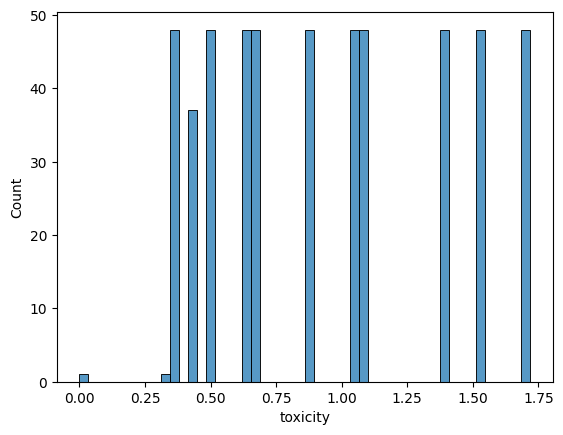

In [10]:
sns.histplot(df_selected.toxicity, bins=50)

<a class="anchor" id="data-split"></a>
#### Splitting Data and Feature Importance

In [73]:
df_full_train, df_test = train_test_split(df_selected, test_size=0.2, shuffle=True, random_state=2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, shuffle=True, random_state=2)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [12]:
print("Full:", round(df.shape[0], 2))
print("Full_train:", round(df_full_train.shape[0], 2))
print("Train:", round(df_train.shape[0], 2))
print("Val:", round(df_val.shape[0], 2))
print("Test:", round(df_test.shape[0], 2))

Full: 555
Full_train: 415
Train: 311
Val: 104
Test: 104


I used the Pandas Profiler to get a more comprehensive look at the training dataset. 

In [13]:
profile = ProfileReport(df_train)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

There's a fairly high correlation between the visual contrasts, which makes sense given they're all measuring similar things. The normalised values of 'vi_brightness' also seem to interact well with the toxicity.

Now I am removing the target variable and its variations from the datasets.

In [74]:
y_train = np.log1p(df_train['toxicity'].values)
y_train_unmodified = df_train['toxicity']
y_val = np.log1p(df_val['toxicity'].values)
y_test = np.log1p(df_test['toxicity'].values)

train_leftovers = df_train[['n_tox', 'toxicity_se', 'toxicity_normalised', 'toxicity_norm_se']]
val_leftovers = df_val[['n_tox', 'toxicity_se', 'toxicity_normalised', 'toxicity_norm_se']]
test_leftovers = df_test[['n_tox', 'toxicity_se', 'toxicity_normalised', 'toxicity_norm_se']]

del df_train['toxicity']
del df_train['n_tox']
del df_train['toxicity_se']
del df_train['toxicity_normalised']
del df_train['toxicity_norm_se']

del df_val['toxicity']
del df_val['n_tox']
del df_val['toxicity_se']
del df_val['toxicity_normalised']
del df_val['toxicity_norm_se']

del df_test['toxicity']
del df_test['n_tox']
del df_test['toxicity_se']
del df_test['toxicity_normalised']
del df_test['toxicity_norm_se']

<a class="anchor" id="baseline"></a>
### Baseline Model

In [75]:
dv = DictVectorizer(sparse=False)
model = LinearRegression()

In [76]:
# Writing a function to transform training data, fit a model, transform validation data, evaluate the model, and return the RMSE value.
# To make testing multiple models easier, the function requires features to be specified. 

def model_evaluation(df_train_eval, df_val_eval, model, features_eval):
    dtrain = df_train_eval[features_eval].to_dict(orient='records')
    x_train = dv.fit_transform(dtrain)
    model.fit(x_train, y_train)

    dval = df_val_eval[features_eval].to_dict(orient='records')
    x_val = dv.transform(dval)
    y_pred = model.predict(x_val)
    return np.sqrt(mean_squared_error(y_val, y_pred))

Training a linear regression model with default parameters and evaluating with RMSE against validation data. 

In [77]:
features = list(df_train.columns)
print(round(model_evaluation(df_train, df_val, model, features), 5))

0.04132


I now go ahead and remove the columns that are variations of the brightness and contrast measures, such as the normalized versions and standard errors. These were included for the research purposes but make no sense to include in the model, as they realistically won't be available to the model. 

In [78]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()
del df_train_copy['vi_bright_se']
del df_train_copy['vi_bright_normalised']
del df_val_copy['vi_bright_se']
del df_val_copy['vi_bright_normalised']

In [79]:
features = list(df_train_copy.columns)

score_baseline = model_evaluation(df_train_copy, df_val_copy, model, features)
print(round(score_baseline, 5))

0.04132


This is the RMSE and model we will treat as baseline, and try to improve it from here. 

Keep in mind that the values of the 'toxicity' column have a very narrow range - going from 0 to ~1.7. As such, our RMSE values will also be similarly low.

In [80]:
# Deleting variation columns from all datasets.

del df_full_train['vi_bright_se']
del df_full_train['vi_bright_normalised']

del df_train['vi_bright_se']
del df_train['vi_bright_normalised']

del df_val['vi_bright_se']
del df_val['vi_bright_normalised']

del df_test['vi_bright_se']
del df_test['vi_bright_normalised']


In [81]:
columns = ['Model', 'Description', 'RMSE']
models_tried = []
models_tried.append(("LinearRegression", "Baseline", score_baseline))
models_tried

[('LinearRegression', 'Baseline', 0.041318076698191465)]

<a class="anchor" id="feature-tuning"></a>
### Feature & Parameter Tuning

<a class="anchor" id="lin-reg"></a>
#### Improving Linear Regression Model

Now that we have a baseline we can try to improve it. The first step I will try is basic scaling of the data to see if there is any improvement in our RMSE.

In [82]:
# The first scaler we try is the MinMaxScaler.

min_max_scaler = MinMaxScaler()
num_cols = df_train.columns[df_train.dtypes != 'object'].delete(0)


In [83]:
df_train_copy = df_train.copy()
df_train_num = min_max_scaler.fit_transform(df_train_copy[num_cols])
df_train_copy[num_cols] = pd.DataFrame(df_train_num, columns=num_cols)

df_val_copy = df_val.copy()
df_val_num = min_max_scaler.transform(df_val_copy[num_cols])
df_val_copy[num_cols] = pd.DataFrame(df_val_num, columns=num_cols)

score = round(model_evaluation(df_train_copy, df_val_copy, model, df_train_copy.columns), 9)
models_tried.append(("LinearRegression", "MinMaxScaling", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)



Model    Description          RMSE
0  LinearRegression       Baseline  0.0413180767
1  LinearRegression  MinMaxScaling  0.0443040140

There is an increase in RMSE by the use of MinMaxScaling, meaning our model's performance worsened. Let's try another type of scaler instead. 

In [24]:
std_scaler = StandardScaler()

In [84]:
df_train_copy = df_train.copy()
df_train_num = std_scaler.fit_transform(df_train_copy[num_cols])
df_train_copy[num_cols] = pd.DataFrame(df_train_num, columns=num_cols)

df_val_copy = df_val.copy()
df_val_num = std_scaler.transform(df_val_copy[num_cols])
df_val_copy[num_cols] = pd.DataFrame(df_val_num, columns=num_cols)

score = model_evaluation(df_train_copy, df_val_copy, model, df_train_copy.columns)
models_tried.append(("LinearRegression", "StandardScaling", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model      Description           RMSE
2  LinearRegression  StandardScaling  0.03885804805
0  LinearRegression         Baseline  0.04131807670
1  LinearRegression    MinMaxScaling  0.04430401400

This time our RMSE score seems to improve.

In our EDA, the correlation between 'toxicity' and the 'vi_chrom_cont' was lower than that of the other variables. I want to see what happens if we drop that feature in training. 

In [85]:
df_train_copy = df_train.copy()
df_train_num = std_scaler.fit_transform(df_train_copy[num_cols])
df_train_copy[num_cols] = pd.DataFrame(df_train_num, columns=num_cols)

df_val_copy = df_val.copy()
df_val_num = std_scaler.transform(df_val_copy[num_cols])
df_val_copy[num_cols] = pd.DataFrame(df_val_num, columns=num_cols)

features = ['pop', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_conspic', 'vi_brightness']
score = model_evaluation(df_train_copy, df_val_copy, model, features)

models_tried.append(("LinearRegression", "StandardScaling, withot vs_chrom_cont", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400

There is improvement over baseline, but not over the scaled version. Now let's try dropping that column again but this time with no scaling either. 

In [86]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

features = ['pop', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_conspic', 'vi_brightness']
score = model_evaluation(df_train_copy, df_val_copy, model, features)

models_tried.append(("LinearRegression", "No scaling, without vs_chrom_cont", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400

This worsened the performance significantly. One last experiment before we move onto tree-based models to see if we can improve the perfomance more: I will try dropping the 'vi_brightness' column, which has a slightly lower correlation. 

I don't think this will cause much improvement, but it's worth a try all the same. 

In [87]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

features = ['pop', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_conspic']
score = model_evaluation(df_train_copy, df_val_copy, model, features)

models_tried.append(("LinearRegression", "No scaling, without v_brightness", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400
5  LinearRegression       No scaling, without v_brightness  0.04824130029

And as expected, our model's performance went much, much lower. Clearly 'vi_brightness' is a column we need to keep around. 

<a class="anchor" id="dec-tree"></a>
#### DecisionTree Models

Let's move on to tree-based models. First we evaluate with a DecisionTreeRegressor and get a default parameter baseline. 

In [88]:
dt = DecisionTreeRegressor(random_state=10)

In [89]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

features = list(df_train_copy.columns.values)
score = model_evaluation(df_train_copy, df_val_copy, dt, features)
score

0.028532727084336712

Let's take this as a baseline for our decision tree model and work from there. 

In [90]:
models_tried.append(("DecisionTree", "Baseline", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
6      DecisionTree                               Baseline  0.02853272708
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400
5  LinearRegression       No scaling, without v_brightness  0.04824130029

The first experiment will be to try scaling the numeric values.

In [91]:
df_train_copy = df_train.copy()
df_train_num = min_max_scaler.fit_transform(df_train_copy[num_cols])
df_train_copy[num_cols] = pd.DataFrame(df_train_num, columns=num_cols)

df_val_copy = df_val.copy()
df_val_num = min_max_scaler.transform(df_val_copy[num_cols])
df_val_copy[num_cols] = pd.DataFrame(df_val_num, columns=num_cols)

features = list(df_train_copy.columns.values)
score = model_evaluation(df_train_copy, df_val_copy, dt, features)

models_tried.append(("DecisionTree", "min_max_scaling", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
6      DecisionTree                               Baseline  0.02853272708
7      DecisionTree                        min_max_scaling  0.02853272708
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400
5  LinearRegression       No scaling, without v_brightness  0.04824130029

Okay, the RMSE worsened. Just for the sake of being thorough, let's try the StandardScaler next. 

In [92]:
df_train_copy = df_train.copy()
df_train_num = std_scaler.fit_transform(df_train_copy[num_cols])
df_train_copy[num_cols] = pd.DataFrame(df_train_num, columns=num_cols)

df_val_copy = df_val.copy()
df_val_num = std_scaler.transform(df_val_copy[num_cols])
df_val_copy[num_cols] = pd.DataFrame(df_val_num, columns=num_cols)

features = list(df_train_copy.columns.values)
score = model_evaluation(df_train_copy, df_val_copy, dt, features)

models_tried.append(("DecisionTree", "std_scaling", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
6      DecisionTree                               Baseline  0.02853272708
7      DecisionTree                        min_max_scaling  0.02853272708
8      DecisionTree                            std_scaling  0.02853272708
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400
5  LinearRegression       No scaling, without v_brightness  0.04824130029

Scaling definitely does not seem to be the way to go for this dataset. Let's try dropping 'vs_chrom_cont', which gave us good results in the linear regression model. 

In [93]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

features = ['pop', 'viewer', 'background', 'noise', 'v_or_d', 'vs_lumin_cont', 'vs_conspic', 'vi_brightness']
score = model_evaluation(df_train_copy, df_val_copy, dt, features)

models_tried.append(("DecisionTree", "without 'vs_chrom_cont", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
6      DecisionTree                               Baseline  0.02853272708
7      DecisionTree                        min_max_scaling  0.02853272708
8      DecisionTree                            std_scaling  0.02853272708
9      DecisionTree                 without 'vs_chrom_cont  0.02853272708
2  LinearRegression                        StandardScaling  0.03885804805
3  LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0  LinearRegression                               Baseline  0.04131807670
4  LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1  LinearRegression                          MinMaxScaling  0.04430401400
5  LinearRegression       No scaling, without v_brightness  0.04824130029

Surprisingly, this seems to have only worsened the performance further. 

There is little else to do with the data itself at this point - time for some parameter tuning using GridsearchCV.

In [94]:
# New model and data prep for GridSearch

tree_model = DecisionTreeRegressor()

df_train_copy = df_train.copy()
df_val_copy = df_val.copy()
dtrain_copy = df_train_copy.to_dict(orient='records')
x_train_copy = dv.fit_transform(dtrain_copy)

In [95]:
# Setting up gridsearch stuff

max_depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_samples_leafs = [1, 2, 5, 10, 15, 20, 100, 200, 500]
max_features = [1.0, "sqrt", "log2", None]
criteria = ["squared_error", "friedman_mse", "absolute_error", "poisson"]

grid = dict(max_depth=max_depths, min_samples_leaf=min_samples_leafs, max_features=max_features, criterion=criteria)
cv = RepeatedKFold(n_repeats=3, random_state=5)
grid_search = GridSearchCV(tree_model, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridr = grid_search.fit(x_train_copy, y_train)


In [96]:
# Getting the results from the gridsearch. 

mean_scores = gridr.cv_results_['mean_test_score']
std_scores = gridr.cv_results_['std_test_score']
params = gridr.cv_results_['params']

columns_grid = ["mean score", "std score", "params"]
grid_results = []

for mean, std, param in zip(mean_scores, std_scores, params):
    grid_results.append((mean, std, param))
grid_results_df = pd.DataFrame(grid_results, columns=columns_grid)


In [97]:
grid_results_df.sort_values(by='mean score', ascending=False)

mean score      std score  \
684  -0.01630066748  0.03322109839   
252  -0.01640263905  0.03345248861   
711  -0.01640345811  0.03345660986   
315  -0.01640345811  0.03345660986   
1035 -0.01650542968  0.03368607124   
...             ...            ...   
1068 -0.24583087304  0.01847258466   
888  -0.24617209232  0.01849000063   
816  -0.24748583421  0.02105927032   
843  -0.24801060332  0.01937664941   
1023 -0.24915460303  0.02590012822   

                                                 params  
684   {'criterion': 'friedman_mse', 'max_depth': Non...  
252   {'criterion': 'squared_error', 'max_depth': 15...  
711   {'criterion': 'friedman_mse', 'max_depth': Non...  
315   {'criterion': 'squared_error', 'max_depth': 20...  
1035  {'criterion': 'absolute_error', 'max_depth': 2...  
...                                                 ...  
1068  {'criterion': 'absolute_error', 'max_depth': N...  
888   {'criterion': 'absolute_error', 'max_depth': 5...  
816   {'criterion': 'absolute_error', 'max_depth': 3...  
843   {'criterion': 'absolute_error', 'max_depth': 4...  
1023  {'criterion': 'absolute_error', 'max_depth': 2...  

[1440 rows x 3 columns]

I pick the parameters of the best performing model - let's check the RMSE against our validation data. 

In [98]:
grid_results_df.iloc[684]['params']

{'criterion': 'friedman_mse',
 'max_depth': None,
 'max_features': 1.0,
 'min_samples_leaf': 1}

In [99]:
dt_tuned = DecisionTreeRegressor(criterion='friedman_mse', max_depth=None, max_features=1.0, min_samples_leaf=1)

In [100]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

features = df_train_copy.columns
score = model_evaluation(df_train_copy, df_val_copy, dt_tuned, features)
score

0.028532727084336712

In [101]:
models_tried.append(("DecisionTree", "optimal tuning parameters", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
6       DecisionTree                               Baseline  0.02853272708
7       DecisionTree                        min_max_scaling  0.02853272708
8       DecisionTree                            std_scaling  0.02853272708
9       DecisionTree                 without 'vs_chrom_cont  0.02853272708
10      DecisionTree              optimal tuning parameters  0.02853272708
2   LinearRegression                        StandardScaling  0.03885804805
3   LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0   LinearRegression                               Baseline  0.04131807670
4   LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1   LinearRegression                          MinMaxScaling  0.04430401400
5   LinearRegression       No scaling, without v_brightness  0.04824130029

It's surprising that this fully tuned model somehow performs worse than our baseline model... 

<a class="anchor" id="XGBoost"></a>
#### XGBoost Models

Moving on from the DecisionTree model, it's time to try XGBoost. Let's start with a baseline model as usual. 

In [102]:
dv = DictVectorizer(sparse=False)

dict_train = df_train.to_dict(orient='records')
x_train = dv.fit_transform(dict_train)
features = dv.get_feature_names()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)

dict_val = df_val.to_dict(orient='records')
x_val = dv.transform(dict_val)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

xgb_params = {'seed': 20, 'eval_metric': 'rmse', 'n_jobs': -1}
model_xgb = xgb.train(xgb_params, dtrain)

c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [103]:
y_pred = model_xgb.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

0.021587821146041502

In [104]:
models_tried.append(("XGBoost", "Baseline", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
11           XGBoost                               Baseline  0.02158782115
6       DecisionTree                               Baseline  0.02853272708
7       DecisionTree                        min_max_scaling  0.02853272708
8       DecisionTree                            std_scaling  0.02853272708
9       DecisionTree                 without 'vs_chrom_cont  0.02853272708
10      DecisionTree              optimal tuning parameters  0.02853272708
2   LinearRegression                        StandardScaling  0.03885804805
3   LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0   LinearRegression                               Baseline  0.04131807670
4   LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1   LinearRegression                          MinMaxScaling  0.04430401400
5   LinearRegression       No scaling, without v_brightness  0.04824130029

Untuned and with all features, we can see XGBoost is performing better than our LinearRegression model and also the DecisionTree regressor. Let's take a look at how a high boost number affects this. 

In [105]:
def xgb_parser(xgb_out):
    results = []

    for line in xgb_out.stdout.strip().split('\n'):
        iter_line, train_line, val_line = line.split('\t')

        iter = int(iter_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((iter, train, val))
    
    columns = ["iter", "train_score", "val_score"]
    resultsdf = pd.DataFrame(results, columns=columns)
    return resultsdf

In [106]:
%%capture output

watchlist = [(dtrain, 'train'), (dval, 'val')]
model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

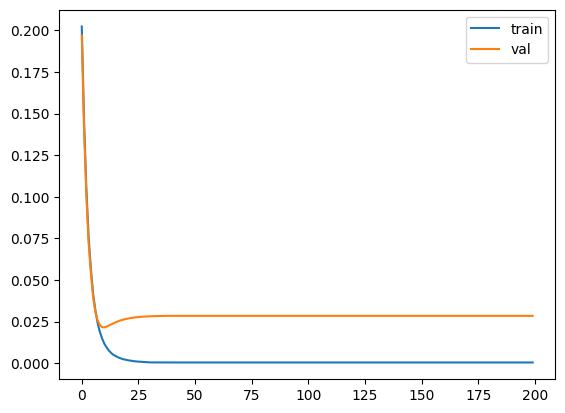

In [107]:
xgb_scores = xgb_parser(output)

# Plotting values to make sure there is no overfitting (increase in validation RMSE while training RMSE decreases)

plt.plot(xgb_scores['iter'], xgb_scores['train_score'], label='train')
plt.plot(xgb_scores['iter'], xgb_scores['val_score'], label='val')
plt.legend()

We see a a significant gap between the performance on the training data vs. the validation data, and this gap develops fairly early on. To find the optimal model, let's look at the values between 0 and 25 boosts, and try and find where the performance is the best. 

In [108]:
xgb_scores.iloc[0:25].sort_values(by='val_score')

iter  train_score  val_score
10    10      0.01157    0.02150
9      9      0.01475    0.02159
11    11      0.00943    0.02197
12    12      0.00752    0.02260
8      8      0.01873    0.02289
13    13      0.00607    0.02330
14    14      0.00494    0.02395
15    15      0.00424    0.02458
16    16      0.00349    0.02513
7      7      0.02408    0.02554
17    17      0.00295    0.02563
18    18      0.00246    0.02604
19    19      0.00217    0.02640
20    20      0.00184    0.02672
21    21      0.00158    0.02698
22    22      0.00141    0.02721
23    23      0.00116    0.02740
24    24      0.00101    0.02757
6      6      0.03185    0.03093
5      5      0.04167    0.03975
4      4      0.05698    0.05445
3      3      0.07629    0.07248
2      2      0.10577    0.10173
1      1      0.14583    0.14124
0      0      0.20235    0.19690

10 iterations seems to be the sweet spot according to the data, and this matches the graph, too. Any more boosts and we start overfitting.

In [109]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = model.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))

models_tried.append(("XGBoost", "num_boost 10", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
11           XGBoost                               Baseline  0.02158782115
12           XGBoost                           num_boost 10  0.02158782115
6       DecisionTree                               Baseline  0.02853272708
7       DecisionTree                        min_max_scaling  0.02853272708
8       DecisionTree                            std_scaling  0.02853272708
9       DecisionTree                 without 'vs_chrom_cont  0.02853272708
10      DecisionTree              optimal tuning parameters  0.02853272708
2   LinearRegression                        StandardScaling  0.03885804805
3   LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0   LinearRegression                               Baseline  0.04131807670
4   LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1   LinearRegression                          MinMaxScaling  0.04430401400
5   LinearRegression       No scaling, without v_brightness  0.04824130029

Let's see if we can improve this score further by dropping 'vi_chrom_cont'.

In [110]:
df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

del df_train_copy['vs_chrom_cont']
del df_val_copy['vs_chrom_cont']

dict_train = df_train_copy.to_dict(orient='records')
x_train = dv.fit_transform(dict_train)
features = dv.get_feature_names()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)

dict_val = df_val_copy.to_dict(orient='records')
x_val = dv.transform(dict_val)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
model = xgb.train(xgb_params, dtrain, num_boost_round=9)

y_pred = model.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))

models_tried.append(("XGBoost", "num_boost 10, dropped chrom_cont", score))
pd.DataFrame(models_tried, columns=columns).sort_values(by='RMSE', ascending=True)

Model                            Description           RMSE
11           XGBoost                               Baseline  0.02158782115
12           XGBoost                           num_boost 10  0.02158782115
13           XGBoost       num_boost 10, dropped chrom_cont  0.02161309016
6       DecisionTree                               Baseline  0.02853272708
7       DecisionTree                        min_max_scaling  0.02853272708
8       DecisionTree                            std_scaling  0.02853272708
9       DecisionTree                 without 'vs_chrom_cont  0.02853272708
10      DecisionTree              optimal tuning parameters  0.02853272708
2   LinearRegression                        StandardScaling  0.03885804805
3   LinearRegression  StandardScaling, withot vs_chrom_cont  0.04075499555
0   LinearRegression                               Baseline  0.04131807670
4   LinearRegression      No scaling, without vs_chrom_cont  0.04131807670
1   LinearRegression                          MinMaxScaling  0.04430401400
5   LinearRegression       No scaling, without v_brightness  0.04824130029

That seems to have lowered our models performance. Going into parameter tuning next, we will include that feature for optimal performance.

>!
> Note that this part takes a long time to run and is resource-heavy.
>!

In [53]:
def model_eval(parameters, x_train_new, y_train_new):
    model = xgb.XGBRegressor()
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=5)
    grid_search = GridSearchCV(model, param_grid=parameters, n_jobs=-1, cv=cv, scoring='neg_root_mean_squared_error')
    grid_result = grid_search.fit(x_train_new, y_train_new)
    gridcv_results = []

    print("Best %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        gridcv_results.append((mean, stdev, param))
    
    columns = ["Mean", "Std_score", "Params"]
    gridcv_results_df = pd.DataFrame(gridcv_results, columns=columns)
    
    return gridcv_results_df


In [54]:
dv = DictVectorizer(sparse=False)

eval_metric = ['rmse']
objectives = ['reg:squarederror']
random_state = [10]

max_depths = [2,3,4,5,6]
min_child_weights = [3,4,5,6,8,10]
colsample_bytrees = [0.2, 0.4, 0.6, 0.8]

parameters = {
    'random_state': random_state,
    'eval_metric': eval_metric,
    'objective': objectives,
    'max_depth': max_depths,
    'min_child_weight': min_child_weights,
    'colsample_bytree': colsample_bytrees
}

df_train_copy = df_train.copy()
dtrain = df_train_copy.to_dict(orient='records')
x_train = dv.fit_transform(dtrain)

learning_params = [
    (1.0, 500),
    (0.3, 800),
    (0.1, 1000),
    (0.05, 1500),
    (0.01, 3000),
]

full_grid_results = pd.DataFrame()

for learning_rate, n_estimators in learning_params:
    print(learning_rate, n_estimators)
    parameters['learning_rate'] = [learning_rate]
    parameters['n_estimators'] = [n_estimators]
    df_gridcv_result = model_eval(parameters, x_train, y_train)
    full_grid_results = pd.concat([full_grid_results, df_gridcv_result], axis=0, ignore_index=True)

1.0 500
Best -0.022026 using {'colsample_bytree': 0.6, 'eval_metric': 'rmse', 'learning_rate': 1.0, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'reg:squarederror', 'random_state': 10}
0.3 800
Best -0.022299 using {'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 800, 'objective': 'reg:squarederror', 'random_state': 10}
0.1 1000
Best -0.021329 using {'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'random_state': 10}
0.05 1500
Best -0.021671 using {'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1500, 'objective': 'reg:squarederror', 'random_state': 10}
0.01 3000
Best -0.022098 using {'colsample_bytree': 0.8, 'eval_metric': 'rmse', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 

Let's try and find the best performing model. 

In [121]:
full_grid_results.sort_values(by='Mean', ascending=False).head(25)

Mean      Std_score  \
338 -0.02132850178  0.02503763417   
336 -0.02141296920  0.02528616890   
458 -0.02167106776  0.02603849242   
452 -0.02171188521  0.02484969308   
450 -0.02181684972  0.02526799134   
456 -0.02195018210  0.02635199943   
339 -0.02199983827  0.02480697581   
84  -0.02202566454  0.01975376716   
576 -0.02209833444  0.02554219870   
340 -0.02213768238  0.02467355822   
330 -0.02214331280  0.02550501267   
342 -0.02222147096  0.02690567368   
228 -0.02229851343  0.02452890433   
588 -0.02238840813  0.02523826257   
453 -0.02241462942  0.02476268809   
334 -0.02242195875  0.02463875660   
468 -0.02242956762  0.02587005072   
332 -0.02248849094  0.02494946679   
337 -0.02253289582  0.02473138885   
454 -0.02261067742  0.02455725809   
210 -0.02263585306  0.02480310717   
348 -0.02268844943  0.02564826759   
451 -0.02270395266  0.02474244062   
582 -0.02278198138  0.02608833015   
230 -0.02278940325  0.02445846021   

                                                Params  
338  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
336  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
458  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
452  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
450  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
456  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
339  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
84   {'colsample_bytree': 0.6, 'eval_metric': 'rmse...  
576  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
340  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
330  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
342  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
228  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
588  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
453  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
334  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
468  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
332  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
337  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
454  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
210  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
348  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
451  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
582  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...  
230  {'colsample_bytree': 0.8, 'eval_metric': 'rmse...

In [118]:
full_grid_results.iloc[338]['Params']

{'colsample_bytree': 0.8,
 'eval_metric': 'rmse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'random_state': 10}

In [127]:
%%capture output

params_tuned = {
 'colsample_bytree': 0.8,
 'eval_metric': 'rmse',
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'objective': 'reg:squarederror',
 'random_state': 10}

dv = DictVectorizer(sparse=False)

df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

dict_train = df_train_copy.to_dict(orient='records')
x_train = dv.fit_transform(dict_train)
features = dv.get_feature_names()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)

dict_val = df_val_copy.to_dict(orient='records')
x_val = dv.transform(dict_val)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)


watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_tuned = xgb.train(params_tuned, dtrain, num_boost_round=1000, evals=watchlist)


In [128]:
df_score = xgb_parser(output)

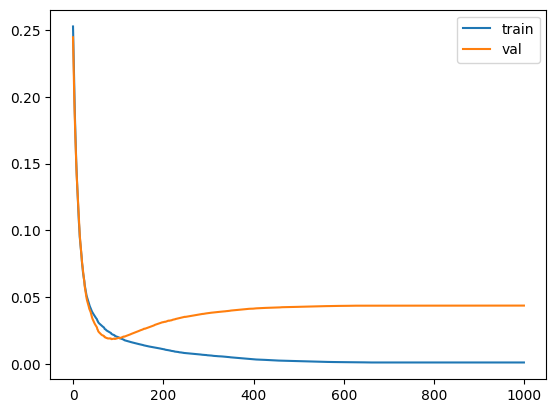

In [129]:
plt.plot(df_score['iter'], df_score['train_score'], label='train')
plt.plot(df_score['iter'], df_score['val_score'], label='val')
plt.legend()

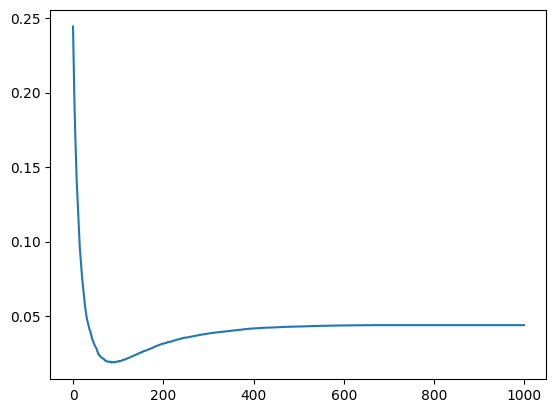

In [130]:
plt.plot(df_score['iter'], df_score['val_score'])

In [133]:
df_score.iloc[:200].sort_values(by="val_score")

iter  train_score  val_score
85    85      0.02275    0.01877
86    86      0.02251    0.01884
87    87      0.02233    0.01886
88    88      0.02219    0.01889
93    93      0.02112    0.01890
..   ...          ...        ...
4      4      0.18758    0.18285
3      3      0.20115    0.19557
2      2      0.21655    0.21010
1      1      0.23591    0.22794
0      0      0.25248    0.24442

[200 rows x 3 columns]

It seems that our lowest score on validation data is by 85 iterations. After that, there is presumably overfitting happening. 

Our previous best was the XGBoost at 0.021 RMSE, so a RMSE of 0.018 is a good improvement post-tuning. This is our best performing model out of all the experiments we've done, so it will be the one we train and use as our final one. 

Just before we train our final model on the full training dataset though, let's do one last training round on df_train and test it against the validation set. 

In [141]:
xgb_params = {
    # 'num_boost_round': 86,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 5,
    'objective': 'reg:squarederror',
    'random_state': 10}

dv = DictVectorizer()

df_train_copy = df_train.copy()
df_val_copy = df_val.copy()

dict_train = df_train_copy.to_dict(orient='records')
x_train = dv.fit_transform(dict_train)
features = dv.get_feature_names()
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)

dict_val = df_val_copy.to_dict(orient='records')
x_val = dv.transform(dict_val)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

model = xgb.train(xgb_params, dtrain, num_boost_round=86)

y_pred = model.predict(dval)
score = np.sqrt(mean_squared_error(y_val, y_pred))
score

c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.01876702133365169

<a class="anchor" id="final"></a>
### Training the final model

In [142]:
xgb_params = {
    # 'num_boost_round': 86,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 3,
    'min_child_weight': 5,
    'objective': 'reg:squarederror',
    'random_state': 10}

dv = DictVectorizer()

df_full_train_copy = df_full_train.copy()
y_full_train = np.log1p(df_full_train_copy['toxicity'].values)

del df_full_train_copy['toxicity']
del df_full_train_copy['n_tox']
del df_full_train_copy['toxicity_se']
del df_full_train_copy['toxicity_normalised']
del df_full_train_copy['toxicity_norm_se']

df_test_copy = df_test.copy()

dict_full_train = df_full_train_copy.to_dict(orient='records')
x_full_train = dv.fit_transform(dict_full_train)
features = dv.get_feature_names()
dfull_train = xgb.DMatrix(x_full_train, label=y_full_train, feature_names=features)

dict_test = df_test_copy.to_dict(orient='records')
x_test = dv.transform(dict_test)
dtest = xgb.DMatrix(x_test, label=y_test, feature_names=features)

model = xgb.train(xgb_params, dfull_train, num_boost_round=86)

y_pred_test = model.predict(dtest)
score = np.sqrt(mean_squared_error(y_test, y_pred_test))
score

c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.011846443133639663

In [ ]:
# bentoml.xgboost.save_model(
#     'frog_toxicity_model',
#     model,
#     custom_objects={
#         'dictVectorizer': dv
#     }
# )